# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [26]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2023 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

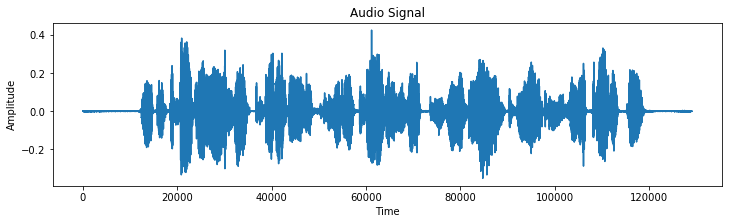

**Shape of Audio Signal** : (129103,)

**Transcript** : mister quilter is the apostle of the middle classes and we are glad to welcome his gospel

In [27]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

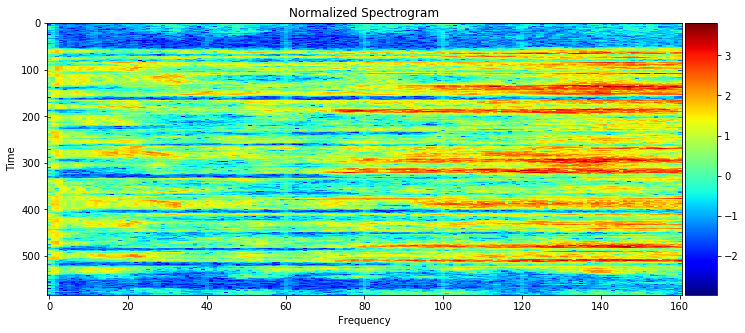

**Shape of Spectrogram** : (584, 161)

In [4]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

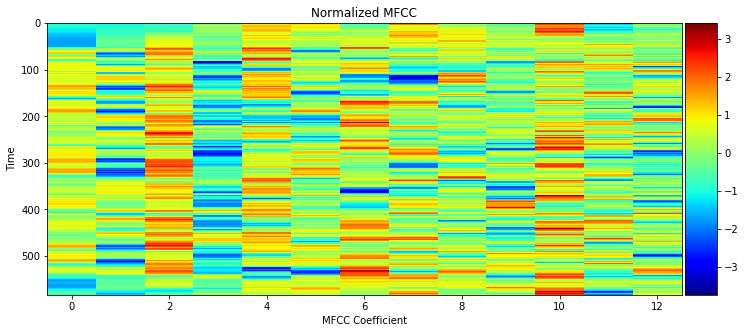

**Shape of MFCC** : (584, 13)

In [5]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

/home/ubuntu/.conda/envs/nlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
import pickle

def show_pickle_results(model_name):
    data = pickle.load(open('results/%s.pickle' % model_name, 'rb'))
    
    for i, val in enumerate(data['loss']):
        print('Epoch %2d/%d: loss: %.04f - val_loss: %.04f' % (i + 1, len(data['loss']), val, data['val_loss'][i]))

<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [3]:
model_0 = simple_rnn_model(input_dim=161) # 161 # change to 13 if you would like to use MFCC features
model_0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [ ]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 174s 2s/step - loss: 846.2240 - val_loss: 739.4100
Epoch 2/20
106/106 [==============================] - 177s 2s/step - loss: 759.5936 - val_loss: 727.3245
Epoch 3/20
106/106 [==============================] - 177s 2s/step - loss: 753.5736 - val_loss: 726.8645
Epoch 4/20
106/106 [==============================] - 176s 2s/step - loss: 751.8332 - val_loss: 726.5551
Epoch 5/20
106/106 [==============================] - 173s 2s/step - loss: 752.5051 - val_loss: 726.1500
Epoch 6/20
106/106 [==============================] - 172s 2s/step - loss: 751.3604 - val_loss: 726.7537
Epoch 7/20
106/106 [==============================] - 172s 2s/step - loss: 752.4907 - val_loss: 726.8813
Epoch 8/20
106/106 [==============================] - 173s 2s/step - loss: 752.6378 - val_loss: 726.7041
Epoch 9/20
106/106 [==============================] - 172s 2s/step - loss: 751.7938 - val_loss: 725.9500
Epoch 10/20
106/106 [==============================] - 

In [15]:
show_pickle_results('model_0')

Epoch  1/20: loss: 846.2240 - val_loss: 739.4100
Epoch  2/20: loss: 759.5936 - val_loss: 727.3245
Epoch  3/20: loss: 753.5736 - val_loss: 726.8645
Epoch  4/20: loss: 751.8332 - val_loss: 726.5551
Epoch  5/20: loss: 752.5051 - val_loss: 726.1500
Epoch  6/20: loss: 751.3604 - val_loss: 726.7537
Epoch  7/20: loss: 752.4907 - val_loss: 726.8813
Epoch  8/20: loss: 752.6378 - val_loss: 726.7041
Epoch  9/20: loss: 751.7938 - val_loss: 725.9500
Epoch 10/20: loss: 753.0921 - val_loss: 727.3977
Epoch 11/20: loss: 752.2337 - val_loss: 726.7559
Epoch 12/20: loss: 752.1412 - val_loss: 726.3993
Epoch 13/20: loss: 752.1256 - val_loss: 726.7096
Epoch 14/20: loss: 751.9020 - val_loss: 726.6890
Epoch 15/20: loss: 751.7173 - val_loss: 726.2821
Epoch 16/20: loss: 751.4643 - val_loss: 726.2669
Epoch 17/20: loss: 752.7480 - val_loss: 726.9188
Epoch 18/20: loss: 752.7256 - val_loss: 726.8636
Epoch 19/20: loss: 751.7035 - val_loss: 726.4829
Epoch 20/20: loss: 752.1024 - val_loss: 726.9179


<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [41]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 176s 2s/step - loss: 302.4460 - val_loss: 246.0689
Epoch 2/20
106/106 [==============================] - 177s 2s/step - loss: 208.7379 - val_loss: 197.5834
Epoch 3/20
106/106 [==============================] - 178s 2s/step - loss: 186.4882 - val_loss: 175.0590
Epoch 4/20
106/106 [==============================] - 176s 2s/step - loss: 166.7448 - val_loss: 159.9441
Epoch 5/20
106/106 [==============================] - 175s 2s/step - loss: 155.2466 - val_loss: 155.0751
Epoch 6/20
106/106 [==============================] - 173s 2s/step - loss: 148.3088 - val_loss: 151.4422
Epoch 7/20
106/106 [==============================] - 173s 2s/step - loss: 143.3591 - val_loss: 145.1637
Epoch 8/20
106/106 [==============================] - 173s 2s/step - loss: 138.8302 - val_loss: 144.2832
Epoch 9/20
106/106 [==============================] - 172s 2s/step - loss: 134.6482 - val_loss: 140.4079
Epoch 10/20
106/106 [==============================] - 

In [2]:
model_1_mfcc = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         activation='relu')
model_1_mfcc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,029
Trainable params: 134,629
Non-trainable params: 400
_________________________________________________________________
None


In [3]:
train_model(input_to_softmax=model_1_mfcc, 
            pickle_path='model_1_mfcc.pickle', 
            save_model_path='model_1_mfcc.h5',
            verbose=2,
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
 - 210s - loss: 397.6672 - val_loss: 257.9786
Epoch 2/20
 - 205s - loss: 235.4675 - val_loss: 255.6312
Epoch 3/20
 - 205s - loss: 220.1625 - val_loss: 208.7266
Epoch 4/20
 - 205s - loss: 220.5198 - val_loss: 347.7507
Epoch 5/20
 - 204s - loss: 201.4618 - val_loss: 213.8086
Epoch 6/20
 - 204s - loss: 183.5812 - val_loss: 194.5774
Epoch 7/20
 - 204s - loss: 172.7386 - val_loss: 176.4493
Epoch 8/20
 - 205s - loss: 165.8237 - val_loss: 170.2056
Epoch 9/20
 - 203s - loss: 161.0324 - val_loss: 168.2581
Epoch 10/20
 - 203s - loss: 167.3771 - val_loss: 165.9799
Epoch 11/20
 - 204s - loss: 214.4970 - val_loss: 642.5389
Epoch 12/20
 - 204s - loss: 225.3281 - val_loss: 246.1552
Epoch 13/20
 - 204s - loss: 224.9363 - val_loss: 225.9085
Epoch 14/20
 - 205s - loss: 224.5660 - val_loss: 215.6213
Epoch 15/20
 - 204s - loss: 224.5558 - val_loss: 215.4944
Epoch 16/20
 - 206s - loss: 224.2386 - val_loss: 213.7309
Epoch 17/20
 - 203s - loss: 224.6612 - val_loss: 213.7786
Epoch 18/20
 - 204s - l

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [2]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 100s 939ms/step - loss: 232.2129 - val_loss: 217.9126
Epoch 2/20
106/106 [==============================] - 95s 900ms/step - loss: 170.2205 - val_loss: 156.3813
Epoch 3/20
106/106 [==============================] - 95s 900ms/step - loss: 147.7244 - val_loss: 143.4855
Epoch 4/20
106/106 [==============================] - 96s 906ms/step - loss: 135.1212 - val_loss: 138.1238
Epoch 5/20
106/106 [==============================] - 96s 902ms/step - loss: 125.8948 - val_loss: 134.9528
Epoch 6/20
106/106 [==============================] - 95s 894ms/step - loss: 118.4602 - val_loss: 131.0745
Epoch 7/20
106/106 [==============================] - 95s 897ms/step - loss: 112.4186 - val_loss: 127.2162
Epoch 8/20
106/106 [==============================] - 95s 892ms/step - loss: 106.6670 - val_loss: 127.4143
Epoch 9/20
106/106 [==============================] - 93s 881ms/step - loss: 101.4676 - val_loss: 126.6737
Epoch 10/20
106/106 [===============

In [16]:
show_pickle_results('model_2')

Epoch  1/20: loss: 232.2129 - val_loss: 217.9126
Epoch  2/20: loss: 170.2205 - val_loss: 156.3813
Epoch  3/20: loss: 147.7244 - val_loss: 143.4855
Epoch  4/20: loss: 135.1212 - val_loss: 138.1238
Epoch  5/20: loss: 125.8948 - val_loss: 134.9528
Epoch  6/20: loss: 118.4602 - val_loss: 131.0745
Epoch  7/20: loss: 112.4186 - val_loss: 127.2162
Epoch  8/20: loss: 106.6670 - val_loss: 127.4143
Epoch  9/20: loss: 101.4676 - val_loss: 126.6737
Epoch 10/20: loss: 97.3673 - val_loss: 129.7115
Epoch 11/20: loss: 92.7752 - val_loss: 128.6196
Epoch 12/20: loss: 88.2794 - val_loss: 129.3661
Epoch 13/20: loss: 84.4438 - val_loss: 131.4594
Epoch 14/20: loss: 80.6277 - val_loss: 130.0465
Epoch 15/20: loss: 77.1128 - val_loss: 133.3787
Epoch 16/20: loss: 73.6973 - val_loss: 134.8647
Epoch 17/20: loss: 70.2933 - val_loss: 137.3493
Epoch 18/20: loss: 67.0294 - val_loss: 141.4029
Epoch 19/20: loss: 64.0460 - val_loss: 143.0217
Epoch 20/20: loss: 60.9661 - val_loss: 145.1908


<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [2]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2)
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 313s 3s/step - loss: 273.2514 - val_loss: 271.0287
Epoch 2/20
106/106 [==============================] - 318s 3s/step - loss: 207.3963 - val_loss: 187.2106
Epoch 3/20
106/106 [==============================] - 319s 3s/step - loss: 175.8986 - val_loss: 165.6386
Epoch 4/20
106/106 [==============================] - 315s 3s/step - loss: 154.0050 - val_loss: 157.5982
Epoch 5/20
106/106 [==============================] - 315s 3s/step - loss: 141.8209 - val_loss: 144.5420
Epoch 6/20
106/106 [==============================] - 316s 3s/step - loss: 133.8325 - val_loss: 141.9056
Epoch 7/20
106/106 [==============================] - 316s 3s/step - loss: 127.6169 - val_loss: 136.9423
Epoch 8/20
106/106 [==============================] - 313s 3s/step - loss: 122.8494 - val_loss: 134.5932
Epoch 9/20
106/106 [==============================] - 313s 3s/step - loss: 119.7722 - val_loss: 137.6823
Epoch 10/20
106/106 [==============================] - 

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [2]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 321s 3s/step - loss: 267.2144 - val_loss: 221.4446
Epoch 2/20
106/106 [==============================] - 311s 3s/step - loss: 208.6921 - val_loss: 198.7721
Epoch 3/20
106/106 [==============================] - 307s 3s/step - loss: 197.0201 - val_loss: 189.6134
Epoch 4/20
106/106 [==============================] - 304s 3s/step - loss: 187.7617 - val_loss: 180.9964
Epoch 5/20
106/106 [==============================] - 304s 3s/step - loss: 179.3420 - val_loss: 175.9738
Epoch 6/20
106/106 [==============================] - 305s 3s/step - loss: 170.8275 - val_loss: 168.6874
Epoch 7/20
106/106 [==============================] - 305s 3s/step - loss: 163.3003 - val_loss: 163.4268
Epoch 8/20
106/106 [==============================] - 306s 3s/step - loss: 156.3847 - val_loss: 157.5223
Epoch 9/20
106/106 [==============================] - 301s 3s/step - loss: 149.8801 - val_loss: 156.5145
Epoch 10/20
106/106 [==============================] - 

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

#### RNN model without batch normalization

In [2]:
model_5 = rnn_without_norm_model(input_dim=161, units=200, activation='relu')
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,029
Trainable params: 223,029
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5', 
            spectrogram=True) 

Epoch 1/20
106/106 [==============================] - 224s 2s/step - loss: 291.0789 - val_loss: 207.7650
Epoch 2/20
106/106 [==============================] - 179s 2s/step - loss: 206.2953 - val_loss: 192.8853
Epoch 3/20
106/106 [==============================] - 178s 2s/step - loss: 193.7913 - val_loss: 183.8159
Epoch 4/20
106/106 [==============================] - 178s 2s/step - loss: 182.1719 - val_loss: 175.9038
Epoch 5/20
106/106 [==============================] - 177s 2s/step - loss: 172.7756 - val_loss: 167.7123
Epoch 6/20
106/106 [==============================] - 176s 2s/step - loss: 163.8478 - val_loss: 160.5503
Epoch 7/20
106/106 [==============================] - 175s 2s/step - loss: 155.8435 - val_loss: 153.6547
Epoch 8/20
106/106 [==============================] - 174s 2s/step - loss: 149.3597 - val_loss: 151.2937
Epoch 9/20
106/106 [==============================] - 175s 2s/step - loss: 143.9208 - val_loss: 147.6105
Epoch 10/20
106/106 [==============================] - 

In [17]:
show_pickle_results('model_5')

Epoch  1/20: loss: 291.0789 - val_loss: 207.7650
Epoch  2/20: loss: 206.2953 - val_loss: 192.8853
Epoch  3/20: loss: 193.7913 - val_loss: 183.8159
Epoch  4/20: loss: 182.1719 - val_loss: 175.9038
Epoch  5/20: loss: 172.7756 - val_loss: 167.7123
Epoch  6/20: loss: 163.8478 - val_loss: 160.5503
Epoch  7/20: loss: 155.8435 - val_loss: 153.6547
Epoch  8/20: loss: 149.3597 - val_loss: 151.2937
Epoch  9/20: loss: 143.9208 - val_loss: 147.6105
Epoch 10/20: loss: 139.2018 - val_loss: 145.5360
Epoch 11/20: loss: 135.3843 - val_loss: 145.1178
Epoch 12/20: loss: 131.4078 - val_loss: 143.0808
Epoch 13/20: loss: 128.4140 - val_loss: 140.9867
Epoch 14/20: loss: 125.8228 - val_loss: 140.1890
Epoch 15/20: loss: 123.0891 - val_loss: 138.4491
Epoch 16/20: loss: 120.7963 - val_loss: 136.5567
Epoch 17/20: loss: 118.7485 - val_loss: 136.1603
Epoch 18/20: loss: 117.3520 - val_loss: 135.5602
Epoch 19/20: loss: 115.2096 - val_loss: 136.7787
Epoch 20/20: loss: 113.3185 - val_loss: 137.5567


#### Model with 1 convolutional layer and 2 recurrent layers

In [2]:
model_6 = cnn_2rnn_dropout_model(input_dim=161, filters=200, kernel_size=11,
                                 conv_stride=2, conv_border_mode='valid',
                                 recur_layers=2, recur_units=200)
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 200)         800       
__________

In [ ]:
train_model(input_to_softmax=model_6, 
            pickle_path='model_6.pickle',
            save_model_path='model_6.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 180s 2s/step - loss: 237.4364 - val_loss: 215.6433
Epoch 2/20
106/106 [==============================] - 161s 2s/step - loss: 185.8488 - val_loss: 180.4844
Epoch 3/20
106/106 [==============================] - 161s 2s/step - loss: 148.0792 - val_loss: 140.5546
Epoch 4/20
106/106 [==============================] - 160s 2s/step - loss: 130.1467 - val_loss: 132.3030
Epoch 5/20
106/106 [==============================] - 159s 2s/step - loss: 118.2124 - val_loss: 130.8264
Epoch 6/20
106/106 [==============================] - 159s 1s/step - loss: 109.0917 - val_loss: 126.6228
Epoch 7/20
106/106 [==============================] - 158s 1s/step - loss: 101.8098 - val_loss: 121.6074
Epoch 8/20
106/106 [==============================] - 159s 1s/step - loss: 95.5580 - val_loss: 122.6137
Epoch 9/20
106/106 [==============================] - 156s 1s/step - loss: 89.8498 - val_loss: 121.0788
Epoch 10/20
106/106 [==============================] - 15

In [18]:
show_pickle_results('model_6')

Epoch  1/20: loss: 237.4364 - val_loss: 215.6433
Epoch  2/20: loss: 185.8488 - val_loss: 180.4844
Epoch  3/20: loss: 148.0792 - val_loss: 140.5546
Epoch  4/20: loss: 130.1467 - val_loss: 132.3030
Epoch  5/20: loss: 118.2124 - val_loss: 130.8264
Epoch  6/20: loss: 109.0917 - val_loss: 126.6228
Epoch  7/20: loss: 101.8098 - val_loss: 121.6074
Epoch  8/20: loss: 95.5580 - val_loss: 122.6137
Epoch  9/20: loss: 89.8498 - val_loss: 121.0788
Epoch 10/20: loss: 84.6053 - val_loss: 119.5633
Epoch 11/20: loss: 79.9019 - val_loss: 119.4727
Epoch 12/20: loss: 75.6059 - val_loss: 120.5995
Epoch 13/20: loss: 71.1471 - val_loss: 119.6952
Epoch 14/20: loss: 67.4108 - val_loss: 123.0289
Epoch 15/20: loss: 63.6915 - val_loss: 123.9000
Epoch 16/20: loss: 60.0901 - val_loss: 125.3140
Epoch 17/20: loss: 57.0646 - val_loss: 128.7623
Epoch 18/20: loss: 53.7433 - val_loss: 131.1751
Epoch 19/20: loss: 50.8007 - val_loss: 132.2103
Epoch 20/20: loss: 48.3201 - val_loss: 138.6271


#### Model with 1 convolutional layer and 2 recurrent layers
RNN layers use 0.5 dropout rate for input connections and 0.2 for recurrent connections.

In [2]:
model_7 = cnn_2rnn_dropout_model(input_dim=161, filters=200, kernel_size=11,
                                 conv_stride=2, conv_border_mode='valid',
                                 recur_layers=2, recur_units=200,
                                 dropout=0.5, recurrent_dropout=0.2)
model_7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 200)         800       
__________

In [3]:
train_model(input_to_softmax=model_7, 
            pickle_path='model_7.pickle',
            save_model_path='model_7.h5',
            verbose=2,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
 - 251s - loss: 642.5365 - val_loss: 621.6240
Epoch 2/20
 - 172s - loss: 643.3032 - val_loss: 621.8267
Epoch 3/20
 - 170s - loss: 642.6913 - val_loss: 622.2134
Epoch 4/20
 - 170s - loss: 643.3660 - val_loss: 622.0553
Epoch 5/20
 - 169s - loss: 642.3633 - val_loss: 622.1011
Epoch 6/20
 - 169s - loss: 642.3859 - val_loss: 621.9194
Epoch 7/20
 - 167s - loss: 643.2080 - val_loss: 621.8881
Epoch 8/20
 - 166s - loss: 642.9333 - val_loss: 622.0127
Epoch 9/20
 - 166s - loss: 642.6701 - val_loss: 621.4561
Epoch 10/20
 - 167s - loss: 641.7592 - val_loss: 621.5276
Epoch 11/20
 - 165s - loss: 642.9486 - val_loss: 621.9531
Epoch 12/20
 - 166s - loss: 642.4808 - val_loss: 621.8521
Epoch 13/20
 - 166s - loss: 643.3080 - val_loss: 621.9531
Epoch 14/20
 - 166s - loss: 642.4991 - val_loss: 622.0853
Epoch 15/20
 - 166s - loss: 642.6720 - val_loss: 621.5177
Epoch 16/20
 - 167s - loss: 643.0605 - val_loss: 622.5359
Epoch 17/20
 - 166s - loss: 642.9428 - val_loss: 621.5797
Epoch 18/20
 - 165s - l

#### Model with 1 convolutional layer and 2 recurrent layers
RNN layers use 0.5 dropout rate only for input connections.

In [2]:
model_8 = cnn_2rnn_dropout_model(input_dim=161, filters=200, kernel_size=11,
                                 conv_stride=2, conv_border_mode='valid',
                                 recur_layers=2, recur_units=200,
                                 dropout=0.5)
model_8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 200)         800       
__________

In [ ]:
train_model(input_to_softmax=model_8, 
            pickle_path='model_8.pickle',
            save_model_path='model_8.h5',
            verbose=2,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
 - 143s - loss: 259.3219 - val_loss: 240.1188
Epoch 2/20
 - 144s - loss: 215.5416 - val_loss: 187.1152
Epoch 3/20
 - 143s - loss: 185.8851 - val_loss: 163.5504
Epoch 4/20
 - 143s - loss: 170.1560 - val_loss: 152.6905
Epoch 5/20
 - 143s - loss: 160.6737 - val_loss: 145.9303
Epoch 6/20
 - 142s - loss: 154.7493 - val_loss: 142.0993
Epoch 7/20
 - 142s - loss: 149.1539 - val_loss: 136.8413
Epoch 8/20
 - 140s - loss: 145.8484 - val_loss: 135.1084
Epoch 9/20
 - 140s - loss: 143.2143 - val_loss: 131.0422
Epoch 10/20
 - 139s - loss: 139.2269 - val_loss: 129.1633
Epoch 11/20
 - 140s - loss: 136.3985 - val_loss: 126.6937
Epoch 12/20
 - 141s - loss: 135.2312 - val_loss: 126.2861
Epoch 13/20
 - 141s - loss: 132.2306 - val_loss: 124.5935
Epoch 14/20
 - 142s - loss: 130.1574 - val_loss: 124.3941
Epoch 15/20
 - 141s - loss: 129.1690 - val_loss: 121.2984
Epoch 16/20
 - 141s - loss: 126.8907 - val_loss: 120.4680
Epoch 17/20
 - 142s - loss: 126.0559 - val_loss: 120.3866
Epoch 18/20
 - 141s - l

In [4]:
train_model(input_to_softmax=model_8, 
            pickle_path='model_8_50epochs.pickle',
            save_model_path='model_8_50epochs.h5',
            verbose=2,
            minibatch_size=64,
            epochs=50,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/50
 - 75s - loss: 289.5454 - val_loss: 248.8981
Epoch 2/50
 - 72s - loss: 230.2503 - val_loss: 214.3874
Epoch 3/50
 - 71s - loss: 222.3780 - val_loss: 214.7111
Epoch 4/50
 - 71s - loss: 213.3742 - val_loss: 197.0096
Epoch 5/50
 - 71s - loss: 203.7933 - val_loss: 184.3607
Epoch 6/50
 - 70s - loss: 191.3513 - val_loss: 176.2623
Epoch 7/50
 - 71s - loss: 182.5923 - val_loss: 167.9372
Epoch 8/50
 - 70s - loss: 174.5557 - val_loss: 163.9254
Epoch 9/50
 - 70s - loss: 167.8223 - val_loss: 153.0676
Epoch 10/50
 - 70s - loss: 162.0310 - val_loss: 149.2057
Epoch 11/50
 - 70s - loss: 157.7601 - val_loss: 145.3490
Epoch 12/50
 - 70s - loss: 154.4343 - val_loss: 142.3377
Epoch 13/50
 - 70s - loss: 150.5958 - val_loss: 137.7614
Epoch 14/50
 - 70s - loss: 147.2339 - val_loss: 136.2341
Epoch 15/50
 - 70s - loss: 144.4495 - val_loss: 133.4542
Epoch 16/50
 - 70s - loss: 141.9664 - val_loss: 133.7797
Epoch 17/50
 - 69s - loss: 138.8316 - val_loss: 130.6929
Epoch 18/50
 - 70s - loss: 136.8869 - va

#### Model with 1 convolutional layer and 2 recurrent layers (300 filters and units)

In [2]:
model_8_300_300 = cnn_2rnn_dropout_model(input_dim=161, filters=300, kernel_size=11,
                                         conv_stride=2, conv_border_mode='valid',
                                         recur_layers=2, recur_units=300,
                                         dropout=0.5)
model_8_300_300.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 300)         531600    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 300)         1200      
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 300)         540900    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 300)         1200      
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 300)         540900    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 300)         1200      
__________

In [3]:
train_model(input_to_softmax=model_8_300_300, 
            pickle_path='model_8_300_50epochs.pickle',
            save_model_path='model_8_300_50epochs.h5',
            verbose=2,
            minibatch_size=64,
            epochs=50,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/50
 - 169s - loss: 299.5949 - val_loss: 240.3190
Epoch 2/50
 - 52s - loss: 234.2695 - val_loss: 243.7586
Epoch 3/50
 - 52s - loss: 226.5991 - val_loss: 216.7965
Epoch 4/50
 - 52s - loss: 213.9904 - val_loss: 192.9045
Epoch 5/50
 - 52s - loss: 200.4979 - val_loss: 187.4856
Epoch 6/50
 - 51s - loss: 190.2939 - val_loss: 184.9527
Epoch 7/50
 - 51s - loss: 177.6621 - val_loss: 162.3832
Epoch 8/50
 - 51s - loss: 169.3712 - val_loss: 157.3037
Epoch 9/50
 - 51s - loss: 161.4253 - val_loss: 153.7890
Epoch 10/50
 - 51s - loss: 155.2109 - val_loss: 143.4397
Epoch 11/50
 - 51s - loss: 150.3536 - val_loss: 140.6502
Epoch 12/50
 - 51s - loss: 145.3352 - val_loss: 137.7490
Epoch 13/50
 - 51s - loss: 140.7289 - val_loss: 132.7795
Epoch 14/50
 - 51s - loss: 137.3586 - val_loss: 129.1105
Epoch 15/50
 - 51s - loss: 134.0560 - val_loss: 126.2935
Epoch 16/50
 - 51s - loss: 130.8841 - val_loss: 125.7289
Epoch 17/50
 - 51s - loss: 128.4967 - val_loss: 126.1690
Epoch 18/50
 - 51s - loss: 125.8954 - v

In [4]:
model_8_200_500 = cnn_2rnn_dropout_model(input_dim=161, filters=200, kernel_size=11,
                                         conv_stride=2, conv_border_mode='valid',
                                         recur_layers=2, recur_units=500,
                                         dropout=0.5)
model_8_200_500.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 500)         1051500   
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 500)         2000      
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 500)         1501500   
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 500)         2000      
__________

In [ ]:
train_model(input_to_softmax=model_8_200_500, 
            pickle_path='model_8_200_500_50epochs.pickle',
            save_model_path='model_8_200_500_50epochs.h5',
            verbose=2,
            minibatch_size=64,
            epochs=30,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/30
 - 63s - loss: 282.3199 - val_loss: 260.2203
Epoch 2/30
 - 60s - loss: 231.5535 - val_loss: 221.2388
Epoch 3/30
 - 60s - loss: 223.9145 - val_loss: 207.7502
Epoch 4/30
 - 60s - loss: 214.1198 - val_loss: 193.4711
Epoch 5/30
 - 60s - loss: 205.1178 - val_loss: 182.3390
Epoch 6/30
 - 59s - loss: 191.6683 - val_loss: 171.0283
Epoch 7/30
 - 60s - loss: 181.4797 - val_loss: 173.3181
Epoch 8/30
 - 59s - loss: 172.5097 - val_loss: 157.1294
Epoch 9/30
 - 59s - loss: 163.1777 - val_loss: 153.2839
Epoch 10/30
 - 60s - loss: 158.8320 - val_loss: 143.8370
Epoch 11/30
 - 59s - loss: 151.7909 - val_loss: 139.2843
Epoch 12/30
 - 60s - loss: 147.4561 - val_loss: 136.2227
Epoch 13/30
 - 60s - loss: 142.6554 - val_loss: 133.1051
Epoch 14/30
 - 60s - loss: 139.0732 - val_loss: 130.3773
Epoch 15/30
 - 59s - loss: 135.2138 - val_loss: 127.3571
Epoch 16/30
 - 60s - loss: 132.2006 - val_loss: 126.8094
Epoch 17/30
 - 59s - loss: 129.6699 - val_loss: 123.9273
Epoch 18/30
 - 59s - loss: 126.4918 - va

In [2]:
model_8_500_200 = cnn_2rnn_dropout_model(input_dim=161, filters=500, kernel_size=11,
                                         conv_stride=2, conv_border_mode='valid',
                                         recur_layers=2, recur_units=200,
                                         dropout=0.5)
model_8_500_200.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 500)         886000    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 500)         2000      
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         420600    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 200)         800       
__________

In [3]:
train_model(input_to_softmax=model_8_500_200, 
            pickle_path='model_8_500_200_50epochs.pickle',
            save_model_path='model_8_500_200_50epochs.h5',
            verbose=2,
            minibatch_size=64,
            epochs=50,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/50
 - 58s - loss: 297.6558 - val_loss: 255.8914
Epoch 2/50
 - 53s - loss: 231.2780 - val_loss: 215.6341
Epoch 3/50
 - 53s - loss: 224.2030 - val_loss: 237.1567
Epoch 4/50
 - 53s - loss: 210.0141 - val_loss: 190.1184
Epoch 5/50
 - 52s - loss: 198.3630 - val_loss: 176.0067
Epoch 6/50
 - 52s - loss: 185.2885 - val_loss: 169.7623
Epoch 7/50
 - 52s - loss: 175.9997 - val_loss: 164.9807
Epoch 8/50
 - 52s - loss: 167.4917 - val_loss: 154.7192
Epoch 9/50
 - 52s - loss: 161.8640 - val_loss: 148.2122
Epoch 10/50
 - 52s - loss: 155.8462 - val_loss: 145.9781
Epoch 11/50
 - 52s - loss: 151.4786 - val_loss: 144.4643
Epoch 12/50
 - 52s - loss: 147.3976 - val_loss: 138.8439
Epoch 13/50
 - 52s - loss: 143.3469 - val_loss: 134.4599
Epoch 14/50
 - 52s - loss: 140.9168 - val_loss: 133.9198
Epoch 15/50
 - 52s - loss: 137.3461 - val_loss: 129.1901
Epoch 16/50
 - 52s - loss: 134.7397 - val_loss: 128.6659
Epoch 17/50
 - 52s - loss: 133.2330 - val_loss: 127.6947
Epoch 18/50
 - 52s - loss: 130.4072 - va

#### Model with 1 convolutional layer and 3 recurrent layers

In [4]:
model_9 = cnn_2rnn_dropout_model(input_dim=161, filters=200, kernel_size=11,
                                 conv_stride=2, conv_border_mode='valid',
                                 recur_layers=3, recur_units=200,
                                 dropout=0.5)
model_9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 200)         800       
__________

In [5]:
train_model(input_to_softmax=model_9, 
            pickle_path='model_9.pickle',
            save_model_path='model_9.h5',
            verbose=2,
            minibatch_size=64,
            epochs=50,
            spectrogram=True)

Epoch 1/50
 - 174s - loss: 312.4562 - val_loss: 249.7877
Epoch 2/50
 - 96s - loss: 233.1980 - val_loss: 238.3587
Epoch 3/50
 - 95s - loss: 226.4261 - val_loss: 234.8175
Epoch 4/50
 - 95s - loss: 228.5709 - val_loss: 212.7063
Epoch 5/50
 - 95s - loss: 221.6186 - val_loss: 206.8485
Epoch 6/50
 - 94s - loss: 215.6202 - val_loss: 204.3020
Epoch 7/50
 - 94s - loss: 205.6779 - val_loss: 190.8815
Epoch 8/50
 - 94s - loss: 191.7422 - val_loss: 177.8243
Epoch 9/50
 - 93s - loss: 181.9077 - val_loss: 171.1804
Epoch 10/50
 - 94s - loss: 174.6787 - val_loss: 163.0409
Epoch 11/50
 - 93s - loss: 169.9275 - val_loss: 156.0497
Epoch 12/50
 - 94s - loss: 164.7135 - val_loss: 151.9351
Epoch 13/50
 - 92s - loss: 160.9780 - val_loss: 151.0915
Epoch 14/50
 - 93s - loss: 158.3335 - val_loss: 145.8955
Epoch 15/50
 - 93s - loss: 155.1305 - val_loss: 141.8058
Epoch 16/50
 - 94s - loss: 152.1259 - val_loss: 141.1005
Epoch 17/50
 - 92s - loss: 150.0069 - val_loss: 137.2437
Epoch 18/50
 - 92s - loss: 147.6210 - v

#### RNN model with 3 recurrent layers and dropout

In [2]:
model_10 = deep_rnn_model(input_dim=161,
                          units=200,
                          recur_layers=3,
                          dropout=0.5)
model_10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 200)         800       
__________

In [3]:
train_model(input_to_softmax=model_10, 
            pickle_path='model_10.pickle',
            save_model_path='model_10.h5',
            verbose=2,
            minibatch_size=64,
            epochs=50,
            spectrogram=True)

Epoch 1/50
 - 219s - loss: 394.8854 - val_loss: 278.8165
Epoch 2/50
 - 183s - loss: 243.5313 - val_loss: 238.3606
Epoch 3/50
 - 184s - loss: 231.6565 - val_loss: 217.1435
Epoch 4/50
 - 183s - loss: 221.9131 - val_loss: 209.6100
Epoch 5/50
 - 183s - loss: 217.2435 - val_loss: 206.3274
Epoch 6/50
 - 184s - loss: 210.6999 - val_loss: 197.5662
Epoch 7/50
 - 182s - loss: 206.4893 - val_loss: 201.2894
Epoch 8/50
 - 183s - loss: 204.9513 - val_loss: 192.2671
Epoch 9/50
 - 181s - loss: 200.3957 - val_loss: 193.5938
Epoch 10/50
 - 180s - loss: 199.5914 - val_loss: 196.2255
Epoch 11/50
 - 179s - loss: 198.5525 - val_loss: 186.4185
Epoch 12/50
 - 180s - loss: 196.4484 - val_loss: 210.6677
Epoch 13/50
 - 180s - loss: 210.5738 - val_loss: 201.4699
Epoch 14/50
 - 180s - loss: 199.8802 - val_loss: 186.4426
Epoch 15/50
 - 179s - loss: 195.6277 - val_loss: 181.9225
Epoch 16/50
 - 179s - loss: 192.5338 - val_loss: 184.8441
Epoch 17/50
 - 178s - loss: 190.8462 - val_loss: 184.6984
Epoch 18/50
 - 178s - l

#### Model with 1 convolutional layer and 3 recurrent layers
The number of filters and number of recurrent units were increased from 200 to 300.

In [42]:
model_11 = cnn_2rnn_dropout_model(input_dim=161, filters=300, kernel_size=11,
                                  conv_stride=2, conv_border_mode='valid',
                                  recur_layers=3, recur_units=300,
                                  dropout=0.5)
model_11.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 300)         531600    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 300)         1200      
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 300)         540900    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 300)         1200      
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 300)         540900    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 300)         1200      
__________

In [7]:
train_model(input_to_softmax=model_11, 
            pickle_path='model_11.pickle',
            save_model_path='model_11.h5',
            verbose=2,
            minibatch_size=64,
            epochs=20,
            spectrogram=True)

Epoch 1/20
 - 126s - loss: 303.6864 - val_loss: 237.8295
Epoch 2/20
 - 119s - loss: 234.2267 - val_loss: 235.0760
Epoch 3/20
 - 119s - loss: 225.9876 - val_loss: 213.8164
Epoch 4/20
 - 119s - loss: 221.8044 - val_loss: 212.6350
Epoch 5/20
 - 119s - loss: 219.6885 - val_loss: 215.3515
Epoch 6/20
 - 119s - loss: 216.4446 - val_loss: 205.0806
Epoch 7/20
 - 118s - loss: 209.0523 - val_loss: 196.9004
Epoch 8/20
 - 118s - loss: 196.6936 - val_loss: 189.6338
Epoch 9/20
 - 118s - loss: 185.0911 - val_loss: 173.8789
Epoch 10/20
 - 117s - loss: 177.9942 - val_loss: 168.4699
Epoch 11/20
 - 118s - loss: 172.0573 - val_loss: 163.7685
Epoch 12/20
 - 117s - loss: 167.1166 - val_loss: 154.5093
Epoch 13/20
 - 117s - loss: 162.4651 - val_loss: 150.8773
Epoch 14/20
 - 117s - loss: 158.6313 - val_loss: 150.8790
Epoch 15/20
 - 117s - loss: 154.3860 - val_loss: 143.7002
Epoch 16/20
 - 117s - loss: 151.7775 - val_loss: 140.1691
Epoch 17/20
 - 117s - loss: 148.6743 - val_loss: 137.5085
Epoch 18/20
 - 117s - l

In [8]:
train_model(input_to_softmax=model_11, 
            pickle_path='model_11_50epochs.pickle',
            save_model_path='model_11_50epochs.h5',
            verbose=2,
            minibatch_size=64,
            epochs=50,
            spectrogram=True)

Epoch 1/50
 - 120s - loss: 140.8343 - val_loss: 130.9013
Epoch 2/50
 - 117s - loss: 136.4935 - val_loss: 128.8347
Epoch 3/50
 - 117s - loss: 134.7085 - val_loss: 126.8619
Epoch 4/50
 - 116s - loss: 132.5073 - val_loss: 126.3051
Epoch 5/50
 - 117s - loss: 130.6812 - val_loss: 124.8721
Epoch 6/50
 - 117s - loss: 130.2796 - val_loss: 123.6570
Epoch 7/50
 - 117s - loss: 126.9117 - val_loss: 123.1136
Epoch 8/50
 - 116s - loss: 126.1863 - val_loss: 122.0702
Epoch 9/50
 - 117s - loss: 124.4771 - val_loss: 119.8625
Epoch 10/50
 - 117s - loss: 123.4001 - val_loss: 117.9341
Epoch 11/50
 - 117s - loss: 121.1924 - val_loss: 118.3113
Epoch 12/50
 - 117s - loss: 119.8647 - val_loss: 117.1629
Epoch 13/50
 - 116s - loss: 118.9085 - val_loss: 116.7620
Epoch 14/50
 - 117s - loss: 117.7483 - val_loss: 116.9135
Epoch 15/50
 - 116s - loss: 116.6811 - val_loss: 116.3115
Epoch 16/50
 - 117s - loss: 116.3612 - val_loss: 115.1891
Epoch 17/50
 - 117s - loss: 115.0433 - val_loss: 113.0157
Epoch 18/50
 - 118s - l

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

In [67]:
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import numpy as np
import _pickle as pickle
from collections import OrderedDict


TrainingResult = namedtuple('TrainingResult', ['title', 'val_loss', 'loss'])

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))

# model titles
model_titles = {
    'model_0':                   '1. RNN',
    'model_0_mfcc':              '2. RNN (MFCC)',
    'model_1':                   '3. RNN+FC',
    'model_1_mfcc':              '4. RNN+FC (MFCC)',
    'model_2':                   '5. Conv+RNN+FC',
    'model_3':                   '6. 2xRNN+FC',
    'model_4':                   '7. BiRNN+FC',
    'model_5':                   '8. RNN+FC (without BN)',
    'model_6':                   '9. Conv+2xRNN+FC',
    'model_7':                  '10. Conv+2x(RNN+Dropout(+recur.))+FC',
    'model_8':                  '11. Conv+2x(RNN+Dropout)+FC (200f, 200u)',
    'model_8_50epochs':         '12. Conv+2x(RNN+Dropout)+FC (200f, 200u)',
    'model_8_300_300_50epochs': '13. Conv+2x(RNN+Dropout)+FC (300f, 300u)',
    'model_8_200_500_30epochs': '14. Conv+2x(RNN+Dropout)+FC (200f, 500u)',
    'model_8_500_200_50epochs': '15. Conv+2x(RNN+Dropout)+FC (500f, 200u)',
    'model_9':                  '16. Conv+3x(RNN+Dropout)+FC (200f, 200u)',
    'model_10':                 '17. 3x(RNN+Dropout)+FC',
    'model_11':                 '18. Conv+3x(RNN+Dropout)+FC (300f, 300u)',
    'model_11_50epochs':        '19. Conv+3x(RNN+Dropout)+FC (300f, 300u)',
}

# extract the loss history for each model
results = OrderedDict()
for pickle_path in all_pickles:
    data = pickle.load(open(pickle_path, 'rb'))
    model_name = pickle_path[8:-7]
    if model_name != 'model_end':
        results[model_name] = TrainingResult(model_titles[model_name], data['val_loss'], data['loss'])


def plot_results(model_names: list):
    fig = plt.figure(figsize=(16,5))

    max_epochs = max([len(results[model_name].loss) for model_name in model_names])
    
    # plot the training loss vs. epoch for each model
    ax1 = fig.add_subplot(121)
    for model_name in model_names:
        result = results[model_name]
        ax1.plot(np.linspace(1, len(result.loss), len(result.loss)), 
                result.loss, label=result.title)

    # clean up the plot
    ax1.legend()  
    ax1.set_xlim([1, max_epochs])
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')

    # plot the validation loss vs. epoch for each model
    ax2 = fig.add_subplot(122)
    for model_name in model_names:
        result = results[model_name]
        ax2.plot(np.linspace(1, len(result.val_loss), len(result.val_loss)), 
                result.val_loss, label=result.title)

    # clean up the plot
    ax2.legend()  
    ax2.set_xlim([1, max_epochs])
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.show()

#### Compare simple models

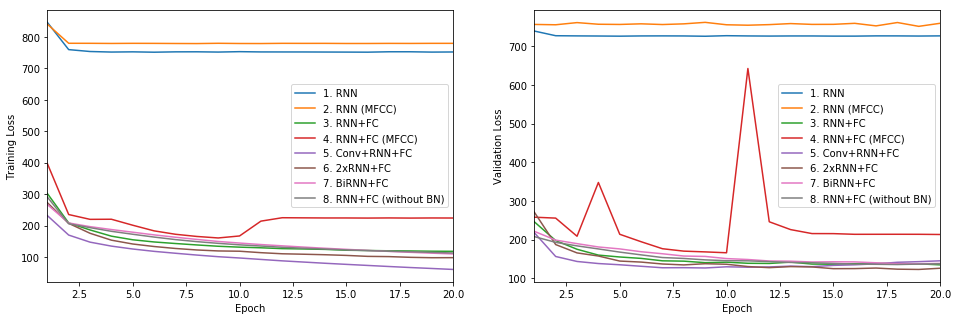

In [22]:
plot_results(['model_0',
              'model_0_mfcc',
              'model_1',
              'model_1_mfcc',
              'model_2',
              'model_3',
              'model_4',
              'model_5'])

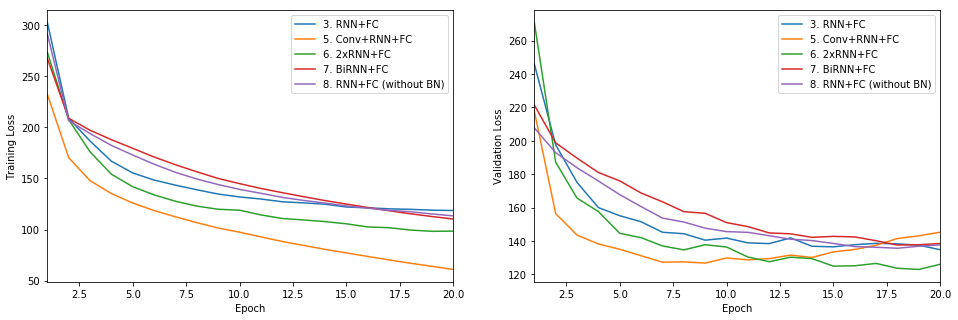

In [23]:
plot_results(['model_1',
              'model_2',
              'model_3',
              'model_4',
              'model_5'])

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__ 

After comparing the results we see that:
- RNN network with one layer is not able to learn the distribution. But once we add one more layer to the network (second RNN layer or fully-connected layer) it shows very good results (plots #1 and #3)
- using of spectrogram gives us much better results than using of MFCC features (plots #3 and #4). The model itself is able to learn much more features from a raw spectogram than MFCC is providing.
- in case of RNN network with 1 layer, batch normalization between reccurent and fully-connected layer doesn't affect the results 
- bidirectional RNN shows the same performance as unidirectional RNN, but it uses 2 times more parameters (plots #7 and #8). It seems next letters can be easily predicted from previous steps only, and the second direction doesn't give us more information.
- network which combines convolutional and RNN layers shows very good results, but starts overfitting the data very quickly (plot #5)


<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

#### Compare more complex models

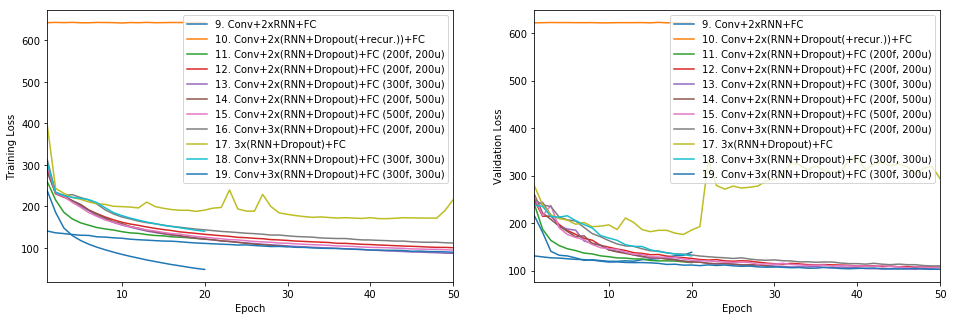

In [68]:
plot_results(['model_6',
              'model_7',
              'model_8',
              'model_8_50epochs',
              'model_8_300_300_50epochs',
              'model_8_200_500_30epochs',
              'model_8_500_200_50epochs',
              'model_9',
              'model_10',
              'model_11',
              'model_11_50epochs'])

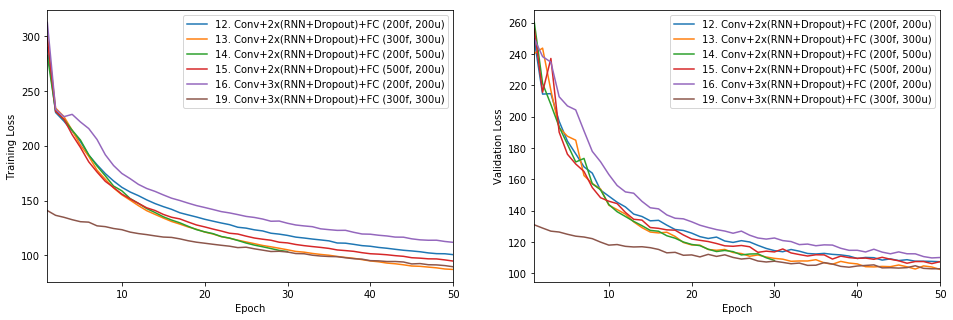

In [71]:
plot_results(['model_8_50epochs',
              'model_8_300_300_50epochs',
              'model_8_200_500_30epochs',
              'model_8_500_200_50epochs',
              'model_9',
              'model_11_50epochs'])

In [39]:
# specify the model
model_end = final_model()
model_end.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 300)         531600    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 300)         1200      
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 300)         540900    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 300)         1200      
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 300)         540900    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 300)         1200      
__________

In [8]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle',
            save_model_path='model_end.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/50
 - 120s - loss: 140.8343 - val_loss: 130.9013
Epoch 2/50
 - 117s - loss: 136.4935 - val_loss: 128.8347
Epoch 3/50
 - 117s - loss: 134.7085 - val_loss: 126.8619
Epoch 4/50
 - 116s - loss: 132.5073 - val_loss: 126.3051
Epoch 5/50
 - 117s - loss: 130.6812 - val_loss: 124.8721
Epoch 6/50
 - 117s - loss: 130.2796 - val_loss: 123.6570
Epoch 7/50
 - 117s - loss: 126.9117 - val_loss: 123.1136
Epoch 8/50
 - 116s - loss: 126.1863 - val_loss: 122.0702
Epoch 9/50
 - 117s - loss: 124.4771 - val_loss: 119.8625
Epoch 10/50
 - 117s - loss: 123.4001 - val_loss: 117.9341
Epoch 11/50
 - 117s - loss: 121.1924 - val_loss: 118.3113
Epoch 12/50
 - 117s - loss: 119.8647 - val_loss: 117.1629
Epoch 13/50
 - 116s - loss: 118.9085 - val_loss: 116.7620
Epoch 14/50
 - 117s - loss: 117.7483 - val_loss: 116.9135
Epoch 15/50
 - 116s - loss: 116.6811 - val_loss: 116.3115
Epoch 16/50
 - 117s - loss: 116.3612 - val_loss: 115.1891
Epoch 17/50
 - 117s - loss: 115.0433 - val_loss: 113.0157
Epoch 18/50
 - 118s - l

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__ After comparing basic models I realised that for this problem it's better to use unidirectional RNNs rather than bidirectional, because the models give the same results, but bidirectional model uses 2 times more parameters. Convolutional layer worked very well with RNN, but it started overfitting the data very quicky. For this reason I added dropout on RNN input connections. It helped me to prevent early overfitting. After I was experementing with different number of RNN layers and different hyperparameters. I trained models with 2 and 3 RNN layers: 3 layers gave me slightly better results than 2 ones, so 4th layer unlikely would improve the results further. I tried to play with other hyperparameters and chose the model which gave me the best validation loss.

So my final model uses convolutional layer and 3 RNN layers with dropout on input connections, convolutional layer has 300 filters, RNN layers have 300 units for hiddden state. To get better results I trained the model 50 epochs. The best validation loss is 102.8331.

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [33]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [36]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(True),
                model_path='results/model_end.h5')

--------------------------------------------------------------------------------
True transcription:

mister quilter is the apostle of the middle classes and we are glad to welcome his gospel
--------------------------------------------------------------------------------
Predicted transcription:

thistercoter is the applusleolf te mea clisses and where gla to wolkom his cost be
--------------------------------------------------------------------------------


Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [37]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(True),
                model_path='results/model_end.h5')

--------------------------------------------------------------------------------
True transcription:

stuff it into you his belly counselled him
--------------------------------------------------------------------------------
Predicted transcription:

sstofirtintoyo his beli cotildim
--------------------------------------------------------------------------------


One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!